## CMS Interpolation
---

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from script import utils, cms, hep
from script.utils import free_mem

from script.hep.data import BalancedSequence, UniformSequence
from script.models.layers import Divide, StandardScaler, Clip
from script.datasets import Benchmark

sns.set()

In [4]:
# for debugging, comment if not needed
%load_ext autoreload
%autoreload 2

In [5]:
utils.set_random_seed(42)

Random seed 42 set.


In [6]:
# statistics
clip = hep.retrieve_clip(ranges=Benchmark.CLIP_RANGES, columns=Benchmark.FEATURES)
mean = hep.retrieve_stat(stats=Benchmark.STATS, which='mean', columns=Benchmark.FEATURES)
std = hep.retrieve_stat(stats=Benchmark.STATS, which='std', columns=Benchmark.FEATURES)

In [7]:
# preprocessing layers
preproc = dict(x=[Clip(min_value=clip[:, 0], max_value=clip[:, 1]),
                  StandardScaler(mean, std)],
               m=[Divide(value=1000.0)])

---

In [8]:
# load training data
data = Benchmark()
data.load(signal='data/benchmark/signal_bassociated_train.csv',
          bkg='data/benchmark/background_train.csv')

[signal] loading...
[background] loading...
dataset loaded.


In [9]:
# load test data
test = Benchmark()
test.load(signal='data/benchmark/signal_bassociated_test.csv',
          bkg='data/benchmark/background_test.csv')

[signal] loading...
[background] loading...
dataset loaded.


In [10]:
data.unique_signal_mass

array([ 110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,  190.,
        200.,  225.,  250.,  275.,  300.,  350.,  400.,  450.,  500.,
        600.,  700.,  800.,  900., 1000.], dtype=float32)

In [11]:
# select training masses (the missing mA are the one we're going to interpolate)
idx = np.arange(start=0, stop=len(data.unique_signal_mass), step=2)

train_mass = data.unique_signal_mass[idx]
train_mass

array([ 110.,  130.,  150.,  170.,  190.,  225.,  275.,  350.,  450.,
        600.,  800., 1000.], dtype=float32)

In [12]:
# create trainining set
interp = Benchmark()
interp.load(signal=pd.concat([data.signal[data.signal['mA'] == m] for m in train_mass]),
            bkg=data.background)

[signal] loading...
[background] loading...
dataset loaded.


In [13]:
free_mem()

22

In [19]:
def compare(paths_and_args: dict, dataset, bins=50):
    models = {}
    
    for path, args in paths_and_args.items():
        name = args.pop('name')
        cls_fn = args.pop('cls', utils.get_compiled_pnn)
        
        model = cls_fn(dataset, **args)
        utils.load_from_checkpoint(model, path=path)
        
        models[name] = model
        
    # ROC & PR
    ax1, ax2 = utils.get_plot_axes(rows=1, cols=2)

    cms.plot.auc_vs_mass(dataset, models, ax=ax1, which='ROC')
    cms.plot.auc_vs_mass(dataset, models, ax=ax2, which='PR')

    plt.tight_layout()
    plt.show()

    # significance
    cms.plot.significance_ratio_vs_mass(dataset, models, bins=bins, title='weighted')

--- 
### Uniform (fixed)
Baseline: fixed, without any *balance* and *preprocessing*.

In [12]:
train, valid = cms.data.train_valid_split(interp)

train = cms.data.SimpleEvalSequence(signal=train[0], background=train[1], batch_size=1024,
                                    features=data.columns['feature'], sample_mass=False,
                                    weight_column=None)

valid = cms.data.SimpleEvalSequence(signal=valid[0], background=valid[1], batch_size=1024,
                                    features=data.columns['feature'])

In [13]:
model, checkpoint = utils.get_compiled_pnn(interp,
                                           save='benchmark/interp/pnn-uniform-fixed', 
                                           lr=3e-4, dropout=0.25,
                                           kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                                           bias_regularizer=tf.keras.regularizers.l2(1e-5))

In [14]:
model.fit(x=train, epochs=50, validation_data=valid, verbose=2, callbacks=[checkpoint])

Epoch 1/50
591/591 - 13s - loss: 0.5278 - binary_accuracy: 0.7193 - auc: 0.6920 - precision: 0.4109 - recall: 0.2705 - ams: 0.5277 - class-loss: 0.9688 - fool-loss: 0.0000e+00 - lr: 3.0000e-04 - grad-norm: 3.7643 - weight-norm: 19.2582 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0369 - val_loss: 0.2398 - val_binary_accuracy: 0.8098 - val_auc: 0.9008 - val_precision: 0.7946 - val_recall: 0.3279 - val_ams: 0.7137
Epoch 2/50
591/591 - 12s - loss: 0.4383 - binary_accuracy: 0.8009 - auc: 0.8453 - precision: 0.6383 - recall: 0.4793 - ams: 0.6434 - class-loss: 0.4502 - fool-loss: 0.0000e+00 - lr: 3.0000e-04 - grad-norm: 0.9134 - weight-norm: 18.6464 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0346 - val_loss: 0.2217 - val_binary_accuracy: 0.8535 - val_auc: 0.9095 - val_precision: 0.7500 - val_recall: 0.6252 - val_ams: 0.7171
Epoch 3/50
591/591 - 12s - loss: 0.3812 - binary_accuracy: 0.8365 - auc: 0.8823 - precision: 0.6990 - recall: 0.6133 - ams: 0.6894 - class-loss: 0.4033 - fool-loss:

In [15]:
utils.load_from_checkpoint(model, path='benchmark/interp/pnn-uniform-fixed')

Loaded from "weights\benchmark/interp/pnn-uniform-fixed\weights-34-0.976"


Loaded from "weights\benchmark/interp/pnn-uniform-fixed\weights-34-0.976"
Loaded from "weights\benchmark/pnn-uniform-fixed\weights-21-0.973"


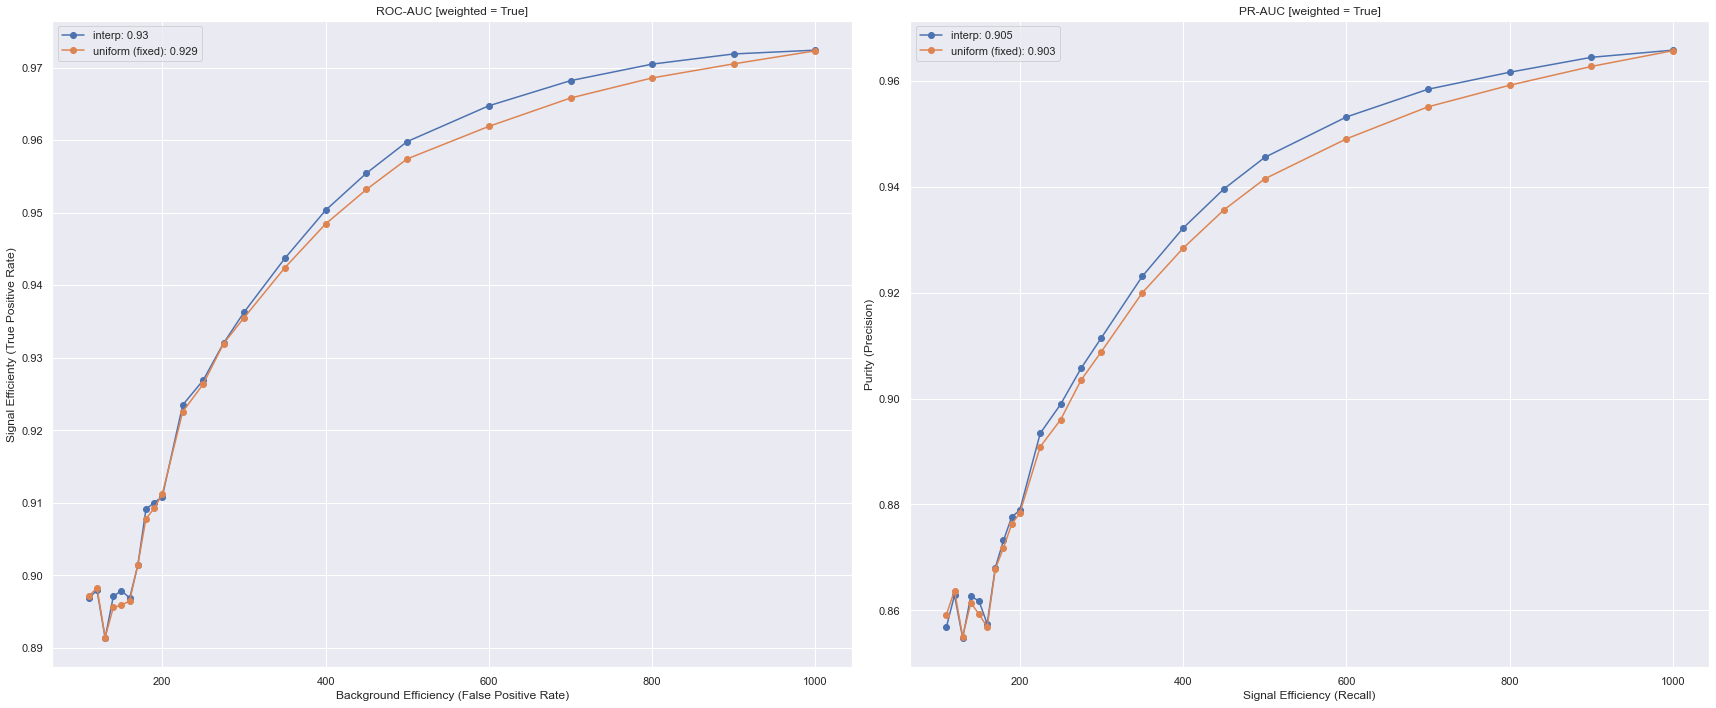

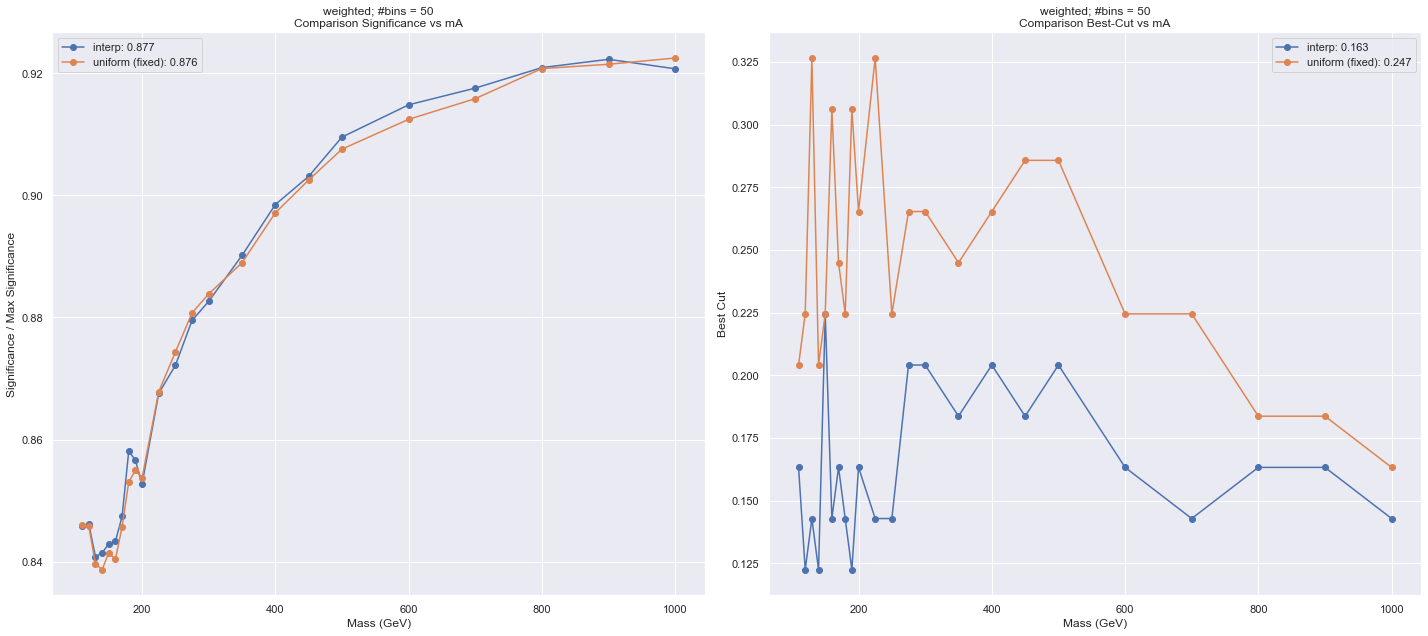

In [25]:
args = dict(dropout=0.25)
base_path ='pnn-uniform-fixed'

compare({f'benchmark/interp/{base_path}': dict(**args, name='interp'),
         f'benchmark/{base_path}': dict(**args, name='uniform (fixed)')}, test)

Preprocessing + full-balance:

In [16]:
del train, valid, model, checkpoint
free_mem()

62

In [14]:
train, valid = cms.data.BalancedUniformSequence.get_data(interp)

In [15]:
model, checkpoint = utils.get_compiled_pnn(interp, dropout=0.25, preprocess=preproc,
                                           save='benchmark/interp/pnn-uniform-fixed-full_balance-preproc', 
                                           kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                                           bias_regularizer=tf.keras.regularizers.l2(1e-5))

In [16]:
model.fit(x=train, epochs=50, validation_data=valid, verbose=2, callbacks=[checkpoint])

Epoch 1/50
800/800 - 15s - loss: 0.2457 - binary_accuracy: 0.8877 - auc: 0.9343 - precision: 0.8884 - recall: 0.9509 - ams: 0.9197 - class-loss: 0.3117 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.2894 - weight-norm: 17.2359 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0296 - val_loss: 0.0642 - val_binary_accuracy: 0.8481 - val_auc: 0.9467 - val_precision: 0.6103 - val_recall: 0.9362 - val_ams: 0.7796
Epoch 2/50
800/800 - 12s - loss: 0.2281 - binary_accuracy: 0.9127 - auc: 0.9526 - precision: 0.9107 - recall: 0.9634 - ams: 0.9369 - class-loss: 0.2499 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.3546 - weight-norm: 13.9796 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0189 - val_loss: 0.0513 - val_binary_accuracy: 0.8401 - val_auc: 0.9516 - val_precision: 0.5941 - val_recall: 0.9574 - val_ams: 0.7994
Epoch 3/50
800/800 - 12s - loss: 0.2410 - binary_accuracy: 0.9163 - auc: 0.9555 - precision: 0.9133 - recall: 0.9661 - ams: 0.9395 - class-loss: 0.2378 - fool-loss: 0.0000e

In [17]:
utils.load_from_checkpoint(model, 
                           path='benchmark/interp/pnn-uniform-fixed-full_balance-preproc')

Loaded from "weights\benchmark/interp/pnn-uniform-fixed-full_balance-preproc\weights-42-0.966"


Evaluation (on all data):

Loaded from "weights\benchmark/interp/pnn-uniform-fixed-full_balance-preproc\weights-42-0.966"
Loaded from "weights\benchmark/pnn-uniform-fixed-full_balance-preproc\weights-14-0.961"


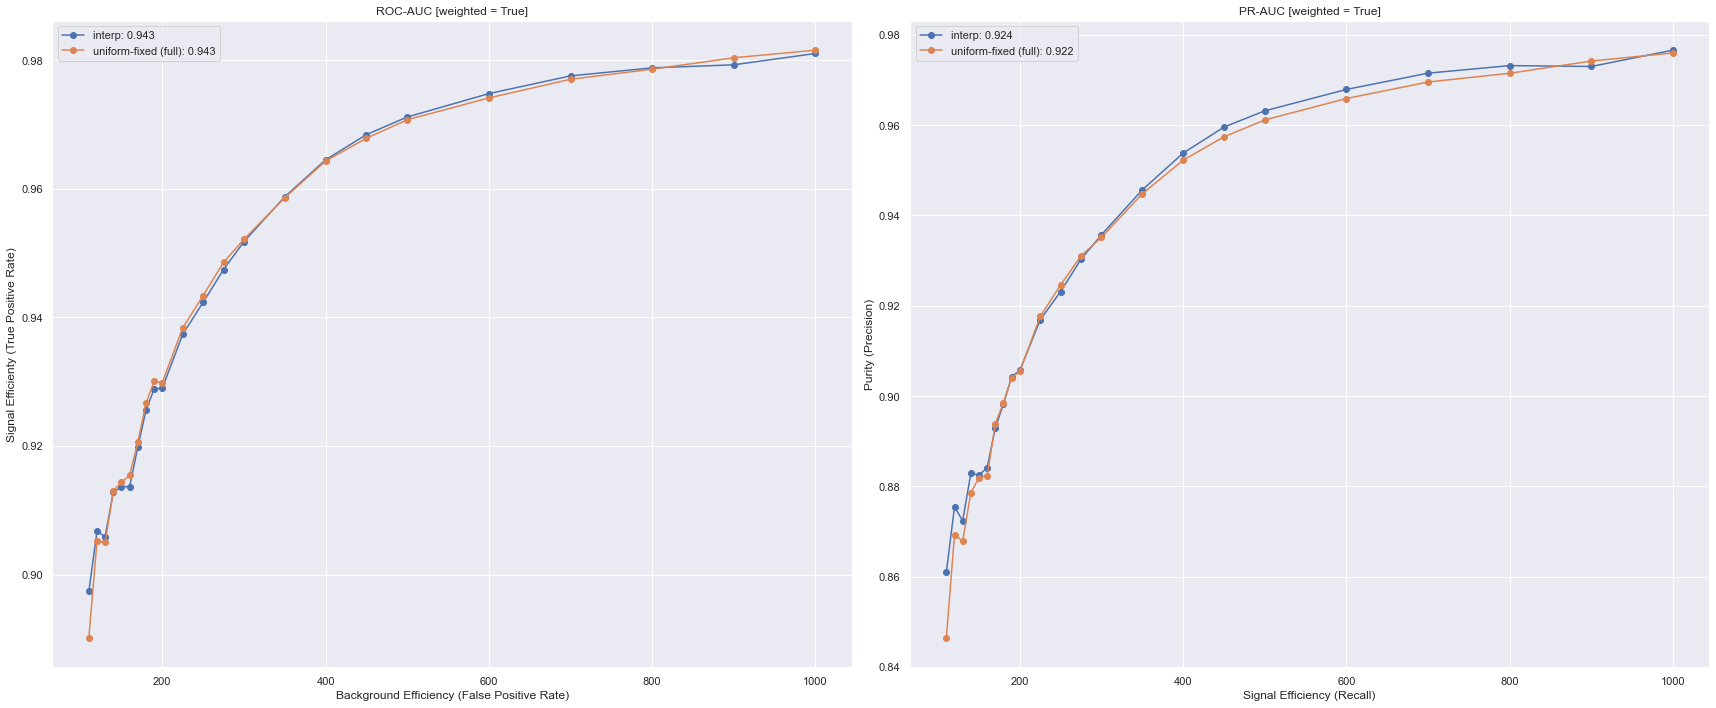

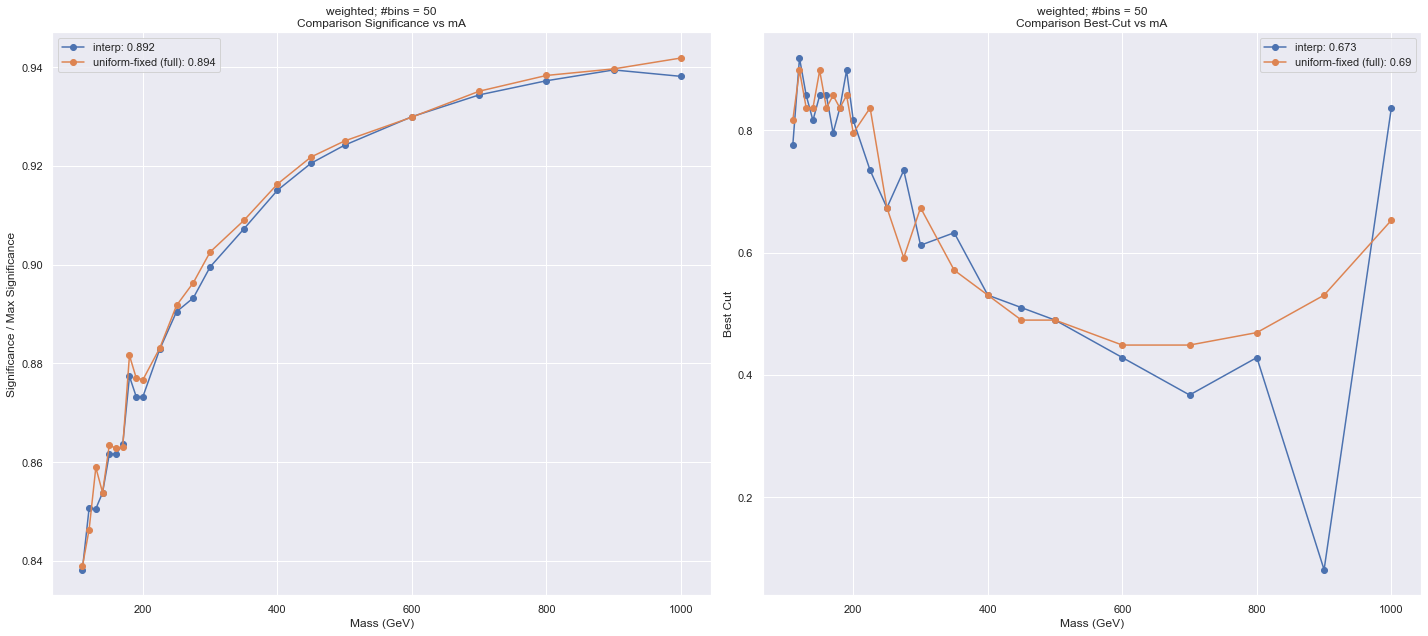

In [20]:
args = dict(dropout=0.25, preprocess=preproc)
base_path ='pnn-uniform-fixed-full_balance-preproc'

compare({f'benchmark/interp/{base_path}': dict(**args, name='interp'),
         f'benchmark/{base_path}': dict(**args, name='uniform-fixed (full)')},
        test)